In [123]:
# Anna Casillas
# ASTR 5830 HW 1

import numpy as np
import scipy.integrate
import scipy.optimize
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [124]:
# 1 Basic Validation and Bandpass Effects

/tmp/ipykernel_124/3103468460.py:21: RuntimeWarning: overflow encountered in exp
  spectral_radiance = (2 * h * c**2) / (wavelength**5) * (1 / (np.exp(exponent) - 1)) * 1e-6


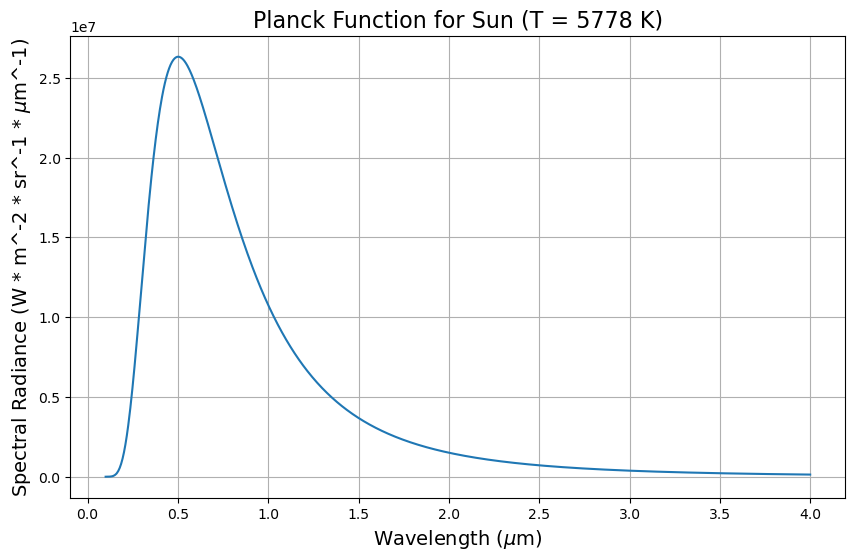

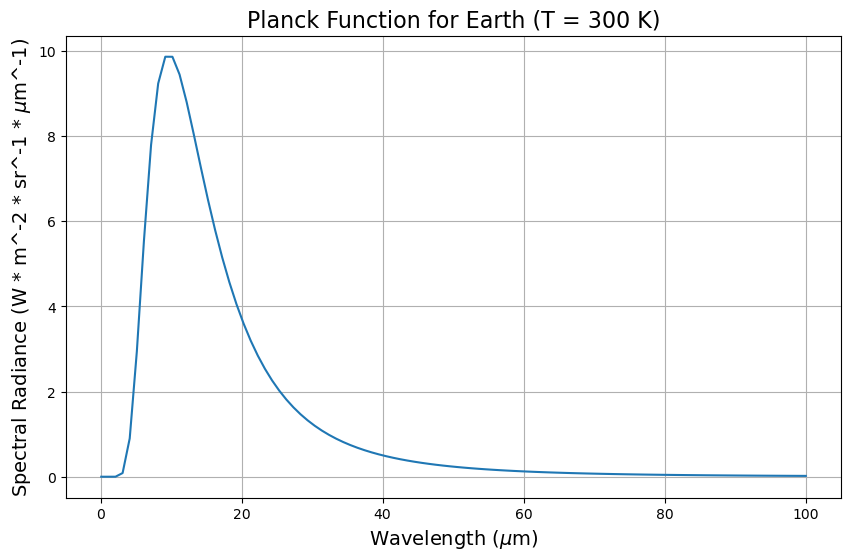

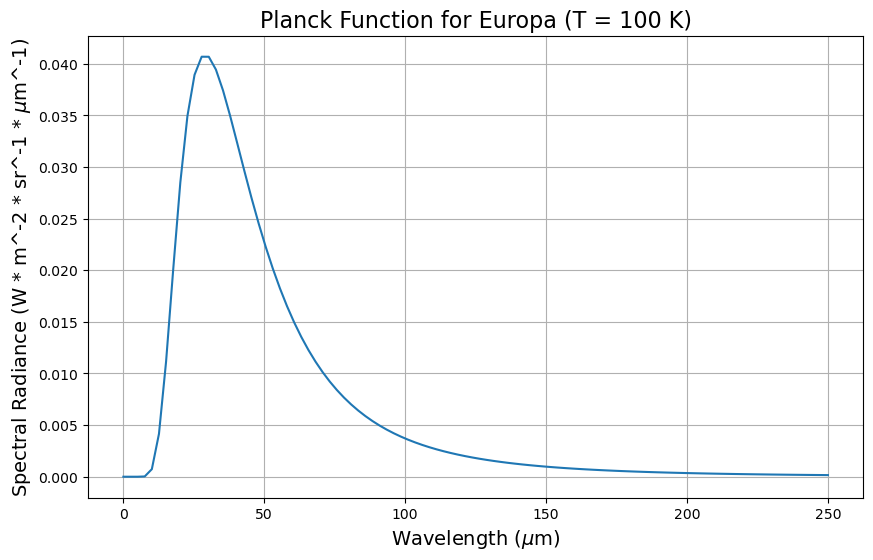

In [125]:
# Plot Planck Function for T = 5778K (Sun), 300K (Earth), 100K (Europa)

# Define Constants
h = 6.62607015e-34  # Planck's constant in J·s
c = 3e8          # speed of light in m/s
k_B = 1.380649e-23  # Boltzmann constant in J/K

def planck_function (wavelength, temperature) :
    """ Calculate spectral radiance from Planck ’s law .

    Args : 
    wavelength ( float or array ) : Wavelength in meters
    temperature ( float ) : Temperature in Kelvin
    
    Returns :
    float or array : Spectral radiance in W .m -2. sr -1. um -1
    """
    
    # Calculate Spectral Radiance in W/m^2/sr/um from Planck's
    exponent = (h * c) / (wavelength * k_B * temperature)
    spectral_radiance = (2 * h * c**2) / (wavelength**5) * (1 / (np.exp(exponent) - 1)) * 1e-6
    
    return spectral_radiance

# Define Wavelengths Range in meters
wavelengthsSun = np.linspace(0.1e-6, 4e-6, 1000)
wavelengthsEarth = np.linspace(0.1e-6, 100e-6, 100)
wavelengthsEuropa = np.linspace(1e-9, 250e-6, 100)

# Define Temperatures in Kelvin
tempSun = 5778
tempEarth = 300
tempEuropa = 100

# Plot the Planck function for Sun
radSun = planck_function(wavelengthsSun, tempSun) # calls function
plt.figure(figsize=(10, 6))
plt.plot(wavelengthsSun * 1e6, radSun)
plt.title("Planck Function for Sun (T = 5778 K)", fontsize=16)
plt.xlabel("Wavelength ($\mu$m)", fontsize=14)
plt.ylabel("Spectral Radiance (W * m^-2 * sr^-1 * $\mu$m^-1)", fontsize=14)
plt.grid(True)

# Plot the Planck function for Earth
radEarth = planck_function(wavelengthsEarth, tempEarth) # calls function
plt.figure(figsize=(10, 6))
plt.plot(wavelengthsEarth * 1e6, radEarth)
plt.title("Planck Function for Earth (T = 300 K)", fontsize=16)
plt.xlabel("Wavelength ($\mu$m)", fontsize=14)
plt.ylabel("Spectral Radiance (W * m^-2 * sr^-1 * $\mu$m^-1)", fontsize=14)
plt.grid(True)

# Plot the Planck function for Europa
radEuropa = planck_function(wavelengthsEuropa, tempEuropa) # calls function
plt.figure(figsize=(10, 6))
plt.plot(wavelengthsEuropa * 1e6, radEuropa)
plt.title("Planck Function for Europa (T = 100 K)", fontsize=16)
plt.xlabel("Wavelength ($\mu$m)", fontsize=14)
plt.ylabel("Spectral Radiance (W * m^-2 * sr^-1 * $\mu$m^-1)", fontsize=14)
plt.grid(True)


In [126]:
# Verify planck inv recovers input temperatures

def planck_inv (wavelength, spectral_radiance) :
    """ Calculate temperature from spectral radiance using Planck ’s law .

    Args :
    wavelength ( float ) : Wavelength in meters
    spectral_radiance ( float ) : Spectral radiance in W .m -2. sr -1. um -1

    Returns :
    float : Temperature in Kelvin
    """

    # Calculate Temperature in Kelvin from Inverse Planck's
    term = (2 * h * c**2) / (wavelength**5 * spectral_radiance * 1e6)
    log_term = np.log(term + 1)
    temperature = (h * c) / (wavelength * k_B * log_term)
    
    return temperature

# Define Wavelength in meters and Calculate Spectral Radiance in W/m^2/sr/um
labels = ['Sun', 'Earth', 'Europa']
wavelength = 1e-6
radiances = [planck_function(wavelength, tempSun), planck_function(wavelength, tempEarth), planck_function(wavelength, tempEuropa)] # calls function

# For Calculated Radiances, Verify Temperature Input
for R, label in zip (radiances,labels):
    temps = planck_inv (wavelength, R)
    print(f"Temperature {label} = {temps} K")
print(f"The planck_inv is verified to recover input temperatures")


Temperature Sun = 5778.0 K
Temperature Earth = 300.0 K
Temperature Europa = 100.0 K
The planck_inv is verified to recover input temperatures


In [145]:
def brightness_temperature (radiance, band_center, band_width) :
    """ Calculate brightness temperature for a given rectangular bandpass .
    
    Implements numerical integration over a rectangular bandpass defined
    by its center wavelength and width. The bandpass is assumed to have
    unity transmission within its bounds and zero outside .

    Args :
    radiance ( float ) : Observed radiance in W .m -2. sr -1. um -1
    band_center ( float ) : Center wavelength of bandpass in meters
    band_width ( float ) : Width of bandpass in meters

    Returns :
    float : Brightness temperature in Kelvin

    Raises :
    ValueError : If band_width <= 0 or band_center <= band_width /2
    """
    
    # Check Input Validity
    if band_width <= 0:
        raise ValueError("band_width must be greater than 0")
    if band_center <= band_width / 2:
        raise ValueError("band_center must be greater than half of band_width")
    
    # Define Wavelength Range for the Bandpass
    lambda_min = band_center - band_width / 2
    lambda_max = band_center + band_width / 2
    
    # Function to Integrate Difference between Planck's Function and Observed Radiance
    def integrand(wavelength, temperature):
        return planck_function(wavelength, temperature) - radiance

    # Function to Calculate the Integral of the Planck Function over the Bandpass
    def bandpass_integral(temperature):
        integral, _ = quad(integrand, lambda_min, lambda_max, args=(temperature,))
        return integral

    # Solve for temperature by numerical methods
    from scipy.optimize import fsolve

    # Use fsolve to find the temperature that gives a zero value for the integral
    temperature_guess = 100  # Initial guess for the temperature in K
    brightnessTemp = fsolve(bandpass_integral, temperature_guess)
    
    return brightnessTemp
    

def radiance (temperature, band_center, band_width) :
    """ Calculate band - integrated radiance for a given temperature and
    rectangular bandpass .

    Integrates Planck function over a rectangular bandpass defined
    by its center wavelength and width . The bandpass is assumed to
    have unity transmission within its bounds and zero outside .

    Args :
    temperature ( float ) : Temperature in Kelvin
    band_center ( float ) : Center wavelength of bandpass in meters

    band_width ( float ) : Width of bandpass in meters
    
    Returns :
    float : Band - integrated radiance in W .m -2. sr -1

    Raises :
    ValueError : If temperature <= 0 , band_width <= 0 , or
    band_center <= band_width /2
    """
    
    # Check Input Validity
    if np.isscalar(temperature):
        if temperature <= 0:
            raise ValueError("Temperature must be greater than 0")
    else:    
        if any(temperature <= 0):
            raise ValueError("Temperature must be greater than 0")
    if band_width <= 0:
        raise ValueError("Band width must be greater than 0")
    if band_center <= band_width / 2:
        raise ValueError("Band center must be greater than half of band_width")

    # Define Wavelength Range for the Bandpass
    lambda_min = band_center - band_width / 2
    lambda_max = band_center + band_width / 2
    wavelengths = np.linspace(lambda_min, lambda_max, 1000)
    
    # Perform Numerical Integration over the Bandpass Range using Planck's Function
    #radiance_int, _ = quad(planck_function, lambda_min, lambda_max, args=(temperature,))
    
    if np.isscalar(temperature):
        rads = planck_function(wavelengths, temperature)
        return scipy.integrate.simpson(rads, x=wavelengths)
    else:
        rads = np.array([planck_function(wavelengths, T) for T in temperature])
        return np.array([scipy.integrate.simpson(R, x=wavelengths) for R in rads])
 

In [146]:
# Show Band-Integrated Radiance Variations with Temperature and Bandwidth

# Define Bandpass Characteristics
temperatures = np.linspace(1,1000,1000)
band_width = 10e-7
band_width2 = 10e-11
band_center = (band_width * 2) + 0.0000000001
band_center2 = (band_width * 2) + 0.0000000001

# Calculate Band-Integrated Radiances
radValues = radiance (temperatures, band_center, band_width)
radValues2 = radiance (temperatures, band_center2, band_width2)
print(f"Band-Integrated Radiance variation with temperature and bandwidth:  ")
#print(radValues)
#print(radValues2)
print(f"Band-Integrated Radiance is larger for greater temperature as seen with larger Plank's function value")
print(f"Band-Integrated Radiance is larger for larger bandwidth due to the greater integration area")


/tmp/ipykernel_124/3103468460.py:21: RuntimeWarning: overflow encountered in exp
  spectral_radiance = (2 * h * c**2) / (wavelength**5) * (1 / (np.exp(exponent) - 1)) * 1e-6


Band-Integrated Radiance variation with temperature and bandwidth:  
Band-Integrated Radiance is larger for greater temperature as seen with larger Plank's function value
Band-Integrated Radiance is larger for larger bandwidth due to the greater integration area


In [147]:
# Real-World Application

In [148]:
# Use Actual Instrument Bandpass Characteristics

# Define Bandpass Characteristics
tempMoon = 400
radMoon = radiance (tempMoon, band_center, band_width)
print(f"Moon Daytime Radiance:  {radMoon} [W/m^2/sr/mum]")

# Calculate Expected Brightness Temperature
brightTempMoon = brightness_temperature (radMoon, band_center, band_width)
print(f"Moon Daytime Brightness Temperature:  {radMoon} [K] ")


Moon Daytime Radiance:  1.4685227571669034e-07 [W/m^2/sr/mum]
Moon Daytime Brightness Temperature:  1.4685227571669034e-07 [K] 


In [142]:
# Implications for Science Measurements:
    
    # band_center represents the peak of the spectral range the instrument can detect and determines which
        # portion EM spectrum being sampled so need's to be close to target's peak emission for higher 
        # sensitivity, signal strength, and SNR
    # band width defines the range of wavelengths around band center instrument can detect, narrow band width
        # leads to finer spectral resolution but smaller integrated radiances and brighteness temperatures 
        # (due to smaller integrater area) and lower SNR
    # higher temperature shifts peak radiation to shorter wavelengths so must be able to adjust band center 
        # and width must be able for optimal measurements as well as drastically increases radiance, which 
        # may affect saturation and exposure times
    